# Lab 2b: getting started with APCEMM
**Tristan Abbott (tristan.abbott@breakthroughenergy.org)**

This lab provides an introduction to the Aircraft Plume Chemistry Emission and Microphysics Model (APCEMM), an intermediate-complexity contrail model developed at the [MIT Laboratory for Aviation and the Environment](https://lae.mit.edu/), and demonstrates how to use a [pycontrails](https://py.contrails.org/) interface to APCEMM to easily run APCEMM using real-world flight and meteorology data.

## Building APCEMM

APCEMM (https://github.com/MIT-LAE/APCEMM) is written in C++ and must be compiled before use. The build process is straightforward but can take up to an hour if dependencies (managed by vcpkg) also have to be built. The first cell below contains commands for building APCEMM locally, with the source code pinned to the most recent commit hash tested in the pycontrails interface. The second cell downloads and unzips the result from building APCEMM in Colab.

Lab attendees should run the second cell to download the pre-built version. (This approach is somewhat fragile--the pre-built version may not work if different Colab instances run on sufficiently different architectures--but building APCEMM from scratch would take up most of the lab.)

In [30]:
# build APCEMM locally (~45 minutes)
!git clone https://github.com/MIT-LAE/APCEMM ~/APCEMM && \
    cd ~/APCEMM && \
    git reset --hard 9d8e1ee && \
    git submodule update --init --recursive && \
    mkdir build && \
    cd build && \
    cmake ../Code.v05-00 && \
    cmake --build .

Cloning into '/home/ext_tristan_abbott_breakthroughe/APCEMM'...
remote: Enumerating objects: 10206, done.
remote: Counting objects: 100% (527/527), done.
remote: Compressing objects: 100% (277/277), done.
remote: Total 10206 (delta 247), reused 480 (delta 231), pack-reused 9679
Receiving objects: 100% (10206/10206), 27.07 MiB | 37.36 MiB/s, done.
Resolving deltas: 100% (6466/6466), done.
HEAD is now at 9d8e1ee Bugfixes for LAGRID model
Submodule 'Code.v05-00/submodules/vcpkg' (https://github.com/Microsoft/vcpkg.git) registered for path 'Code.v05-00/submodules/vcpkg'
Cloning into '/home/ext_tristan_abbott_breakthroughe/APCEMM/Code.v05-00/submodules/vcpkg'...
Submodule path 'Code.v05-00/submodules/vcpkg': checked out '2a6371b01420d8820d158b4707e79931feba27aa'
-- Bootstrapping vcpkg before install
-- Bootstrapping vcpkg before install - done
-- Running vcpkg install
Fetching registry information from https://github.com/microsoft/vcpkg (HEAD)...
Detecting compiler hash for triplet x64-linu

In [ ]:
# download results from building APCEMM in Colab (<5 minutes)
!cd ~ && wget https://storage.googleapis.com/2024-06-contrails-workshop/apcemm/APCEMM.zip && unzip APCEMM.zip && rm APCEMM.zip

## Installing pycontrails

This command installs pycontrails plus all optional dependencies besides `jupyter`, which conflicts with Colab requirements.

In [31]:
!pip install "pycontrails[ecmwf,gcp,gfs,goes,pyproj,vis,zarr] @ git+https://github.com/contrailcirrus/pycontrails@feature/apcemm-interface"

  Cloning https://github.com/contrailcirrus/pycontrails (to revision feature/apcemm-interface) to /tmp/pip-install-u1_kwl_w/pycontrails_338162d8b8fd45118bafb65de1303839
  Running command git clone --filter=blob:none --quiet https://github.com/contrailcirrus/pycontrails /tmp/pip-install-u1_kwl_w/pycontrails_338162d8b8fd45118bafb65de1303839
  Running command git checkout -b feature/apcemm-interface --track origin/feature/apcemm-interface
  Switched to a new branch 'feature/apcemm-interface'
  branch 'feature/apcemm-interface' set up to track 'origin/feature/apcemm-interface'.
  Resolved https://github.com/contrailcirrus/pycontrails to commit 449fed99caf63e1e00efb507f3301eb82ebebb2e
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


## Case 1: APCEMM with idealized meteorology

We will use an idealized case (a contrail that forms in an ISSR of finite depth and limited time duration) to demonstrate the workflow for a single APCEMM simulation.

### Step 1a: constructing meteorology input file

APCEMM expects meteorology data to be provided in a netCDF file that contains a timeseries of atmospheric profiles along the Lagrangian trajectory of an advected contrail segment. Note that the trajectory of the advected segment must be estimated *before* running APCEMM. Unlike CoCiP, APCEMM does not internally track changes to contrail position over time.

APCEMM requires pressure at t = 0 plus time-varying temperature, RH over ice, and segment-normal wind shear as input. We will use the pressure and temperature profiles from the [International Standard Atmosphere](https://en.wikipedia.org/wiki/International_Standard_Atmosphere), a simple step function for RHi, and a constant value of 0.01 1/s for segment-normal shear. 

In [248]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

In [264]:
z = np.linspace(0, 20, 41)  # altitude (km)
t = np.linspace(0, 4, 49)  # elapsed time (hours)

In [266]:
zz, tt = np.meshgrid(z, t, indexing="ij")

In [267]:
p = np.where(
    z < 11.0,
    101325*(1 - 6.5*z/288.15)**(9.80/(6.5e-3*287)),
    22632*np.exp(-9.80*(z - 11)*1e3/(287*216.65))
)
T = np.where(zz < 11.0, 288.15 - 6.5*zz, 216.65)
rhi = np.where((tt <= 0.5) & (zz > 9) & (zz < 11), 1.2, 0.2)
shear = np.full_like(zz, 0.01)

In [268]:
ds = xr.Dataset(data_vars = {
    "pressure": (("altitude",), p/100, {"units": "hPa"}),
    "temperature": (("altitude", "time"), T, {"units": "K"}),
    "relative_humidity_ice": (("altitude", "time"), rhi*100, {"units": "percent"}),
    "shear": (("altitude", "time"), shear, {"units": "1/s"})
}, coords = {
    "altitude": ("altitude", z, {"units": "km"}),
    "time": ("time", t, {"units": "hours"})
})  

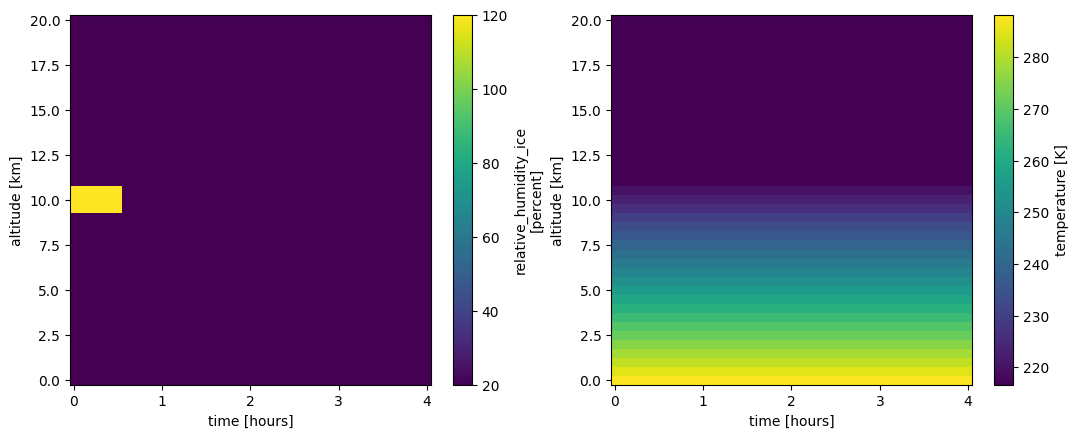

In [269]:
plt.figure(figsize=(12.8, 4.8))
plt.subplot(121)
ds["relative_humidity_ice"].plot()
plt.subplot(122)
ds["temperature"].plot()

### Step 1b: constructing input YAML file

Most APCEMM input parameters are configured in a YAML file. The file format is largely self-describing, and examples distributed with APCEMM include explanatory comments. We will generate the YAML file using some pycontrails utilities that expose many (but, for now, not all) of the YAML file parameters.

The pycontrails utilities require that the user provide
- the initial exhaust plume location (we will pick an arbitrary location)
- meteorological conditions at the point of emission (we will derive these from the idealized meteorology dataset)
- aircraft performance and emissions parameters (we will use nominal values)

Other YAML parameters are set to reasonable default values but can be overriden by the user. Note that the default time step for APCEMM numerics is set to 1 minute, a conservative value that is likely shorter than required.

In [270]:
from pycontrails.models.apcemm import utils
from pycontrails.models.apcemm.inputs import APCEMMInput
from pycontrails.physics import thermo

In [271]:
iz = 20  # form contrail at 10 km
theta = T[:,0]*(p[0]/p)**(287/1000)
params = APCEMMInput(
    # required parameters
    longitude=0,
    latitude=45,
    day_of_year=1,
    hour_of_day=12,
    air_pressure=p[iz],
    air_temperature=T[iz,0],
    rhw=rhi[iz,0]*thermo.e_sat_ice(T[iz,0])/thermo.e_sat_liquid(T[iz,0]),
    normal_shear=shear[iz,0],
    brunt_vaisala_frequency=np.sqrt((theta[iz+1] - theta[iz-1])/(z[iz+1] - z[iz-1])/theta[iz]),
    nox_ei=10e-3,
    co_ei=1e-3,
    hc_ei=0.6e-3,
    so2_ei=1.2e-3,
    nvpm_ei_m=0.008e-3,
    soot_radius=20e-9,
    fuel_flow=0.7,
    aircraft_mass=1e5,
    true_airspeed=260.0,
    n_engine=2,
    wingspan=35,
    core_exit_temp=550,
    core_exit_area=1,
    # optional parameters
    max_age=np.timedelta64(4, "h"),  # stop after no more than 4 hours
    dt_input_met=np.timedelta64(5, "m"),  # must match time step of met input file
    dt_apcemm_nc_output=np.timedelta64(5, "m")  # frequency of netcdf output files
)

### Step 2: write input files to disk and run APCEMM

In [272]:
import os

In [273]:
!rm -r ~/APCEMM_run/case_1

In [274]:
rundir = os.path.expanduser("~/APCEMM_run/case_1")
os.makedirs(rundir, exist_ok=True)

with open(os.path.join(rundir, "input.yaml"), "w") as f:
    yaml = utils.generate_apcemm_input_yaml(params)
    f.write(yaml)

ds.to_netcdf(os.path.join(rundir, "input.nc"))

In [275]:
!cd ~/APCEMM_run/case_1 && ~/APCEMM/build/APCEMM input.yaml

 -> Running case 0 on thread 0
running epm... 
Calculated Timestep: 1[min]
/home/ext_tristan_abbott_breakthroughe/APCEMM_run/case_1/out
Saving TS_AERO files to: /home/ext_tristan_abbott_breakthroughe/APCEMM_run/case_1/out/ts_aerosol_case0_hhmm.nc
Temperature      = 223.178 K
RHw              = 73.3714 %
RHi              = 120 %
Saturation depth = 600.721 m
Ice_den=225.403
Parameterized vortex sinking survival fraction: 1
Initial Contrail Width: 125.331
Initial Contrail Depth: 35.6737
EPM Num Particles: 7.91458e+11
Initial Num Particles: 7.91458e+11
Initial Ice Mass: 0.0286865
Save Complete


 - Time step: 1 out of 241
 -> Solar time: 12 [hr]
Running Transport
Running ice growth...
Updating Met...
Remapping... 
dx: 20, dy: 5
Num Particles: 6.82395e+11
Ice Mass: 0.0522369
Saving Aerosol... 


 - Time step: 2 out of 241
 -> Solar time: 12.0167 [hr]
Running Transport
Running ice growth...
Updating Met...
Remapping... 
dx: 20, dy: 5
Num Particles: 6.71599e+11
Ice Mass: 0.0929497
Saving Aero

### Step 3: view output

The APCEMM simulation created two types output files inside a subdirectory called `out`:
- `Micro000000.out`: output from the "early plume model"; i.e., the parameterization of the aircraft exhaust plume and downwash vortex, formatted as a CSV file
- `ts_aerosol_case0_HHMM.nc`: output from a finite volume model of the contrail cross-section initialized from the early plume model, formatted as netCDF files with HHMM replaced by the hour and minute of the simulation when each file was written.

In [278]:
import pandas as pd

The early plume model resolves the transient spike in relative humidity as the exhaust plume mixes with ambient air:

In [286]:
df = pd.read_csv(os.path.join(rundir, "out", "Micro000000.out"), skiprows=[1]).rename(columns=lambda x: x.strip())

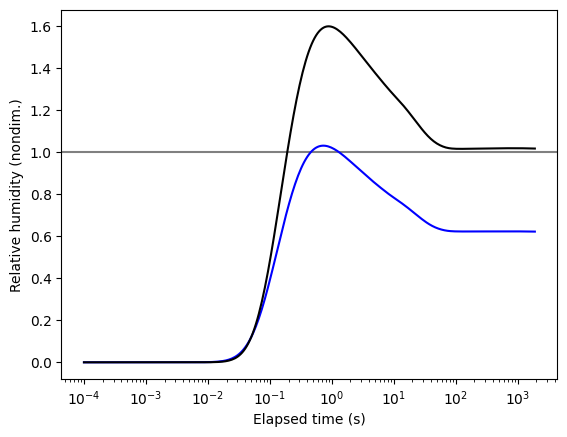

In [291]:
plt.plot(df["Time [s]"], df["RH_w [-]"], "b-", label="over water")
plt.plot(df["Time [s]"], df["RH_i [-]"], "k-", label="over ice")
plt.xlabel("Elapsed time (s)")
plt.ylabel("Relative humidity (nondim.)")
plt.gca().set_xscale("log")
plt.gca().axhline(y=1, color="gray", zorder=-1)

The finite-volume model simulates the evolution of the contrail that forms from the exhaust plume. It relaxes the Gaussian plume assumption used by CoCiP...

Text(0.98, 0.98, '02:30')

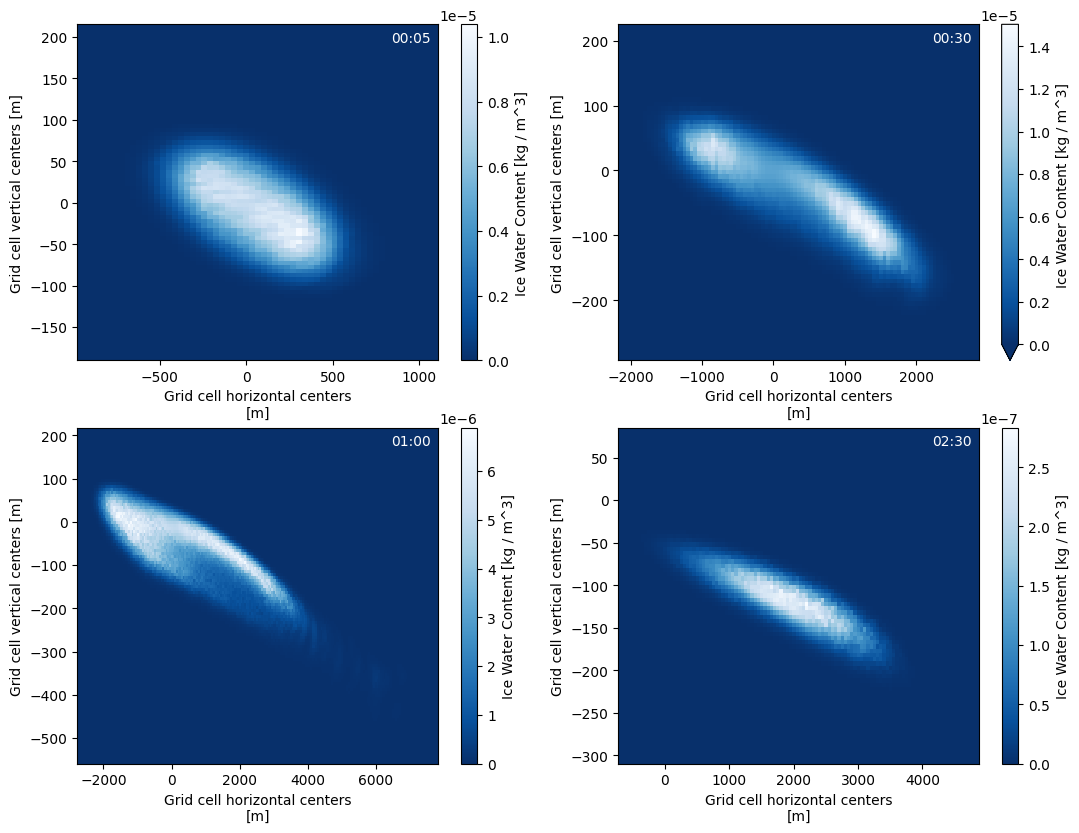

In [305]:
plt.figure(figsize=(12.8, 9.6))
plt.subplot(221)
ds = xr.open_dataset(os.path.join(rundir, "out", "ts_aerosol_case0_0010.nc"), decode_cf=False)
ds["IWC"].plot(cmap="Blues_r", vmin=0)
plt.annotate("00:10", xy=(0.98, 0.98), xycoords="axes fraction", va="top", ha="right", color="white")

plt.subplot(222)
ds = xr.open_dataset(os.path.join(rundir, "out", "ts_aerosol_case0_0030.nc"), decode_cf=False)
ds["IWC"].plot(cmap="Blues_r", vmin=0)
plt.annotate("00:30", xy=(0.98, 0.98), xycoords="axes fraction", va="top", ha="right", color="white")

plt.subplot(223)
ds = xr.open_dataset(os.path.join(rundir, "out", "ts_aerosol_case0_0100.nc"), decode_cf=False)
ds["IWC"].plot(cmap="Blues_r", vmin=0)
plt.annotate("01:00", xy=(0.98, 0.98), xycoords="axes fraction", va="top", ha="right", color="white")

plt.subplot(224)
ds = xr.open_dataset(os.path.join(rundir, "out", "ts_aerosol_case0_0230.nc"), decode_cf=False)
ds["IWC"].plot(cmap="Blues_r", vmin=0)
plt.annotate("02:30", xy=(0.98, 0.98), xycoords="axes fraction", va="top", ha="right", color="white")

... and explicitly simulates the evolution of the ice crystal size distribution.

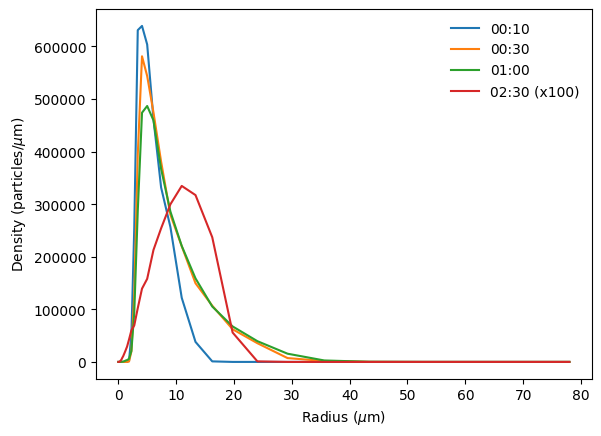

In [323]:
plt.figure()

ds = xr.open_dataset(os.path.join(rundir, "out", "ts_aerosol_case0_0010.nc"), decode_cf=False)
plt.plot(ds["r"]*1e6, ds["Overall size distribution"]/1e6, label="00:10")

ds = xr.open_dataset(os.path.join(rundir, "out", "ts_aerosol_case0_0030.nc"), decode_cf=False)
plt.plot(ds["r"]*1e6, ds["Overall size distribution"]/1e6, label="00:30")

ds = xr.open_dataset(os.path.join(rundir, "out", "ts_aerosol_case0_0100.nc"), decode_cf=False)
plt.plot(ds["r"]*1e6, ds["Overall size distribution"]/1e6, label="01:00")

ds = xr.open_dataset(os.path.join(rundir, "out", "ts_aerosol_case0_0230.nc"), decode_cf=False)
plt.plot(ds["r"]*1e6, ds["Overall size distribution"]/1e6*100, label="02:30 (x100)")

plt.xlabel(r"Radius ($\mu$m)")
plt.ylabel(r"Density (particles/$\mu$m)")
plt.legend(loc="upper right", frameon=False)